# Brain sphere SAR surface integral
This notebook processes old MMP data files for calculating the WBA SAR of a brain sphere canonical problem using a surface integral of the time averaged Poynting vector.

See: `OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\antennas\brain sphere`

And: `OneDrive\@my work\EMF & thermal modelling\MMP_NT\DATA\canonical\XFDTD_spheres`

## Set up

In [1]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import other modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

## Import data from integral file
The imported file is the integral input section from `mmp_3di.400`.

Here we want to see how the surface points are distributed.

In [2]:
integralfile = '../antennas/brain sphere/MMP results/mmp integral input.400'
df = pd.read_csv(integralfile,sep='\s+',skiprows=2,names=('x','y','z'))
df = df.iloc[::3,:]
df

,x,y,z
0,0.099981,0.001388,0.001388
3,0.099827,0.005439,0.002253
6,0.099518,0.009613,0.001912
9,0.099057,0.013533,0.002143
12,0.098443,0.017469,0.001968
...,...,...,...
6111,0.001963,-0.098424,0.017576
6114,0.001963,-0.099038,0.013699
6117,0.001963,-0.099499,0.009800
6120,0.001963,-0.099807,0.005886


## Display points

In [3]:
def showpoints(df):
    '''Show integral points'''

    # create the Mayavi figure
    from mayavi import mlab
    fig = mlab.figure(1, size=(1200,900), bgcolor=(0.3, 0.3, 0.3))
    mlab.clf()

    # draw the integral points
    mlab.points3d(df.x,df.y,df.z,scale_factor=0.001,color=(1,1,0),opacity=1)

    # Draw the scene
    fig.scene.parallel_projection = True
    mlab.show()

In [4]:
showpoints(df)

The 3D visualisation shows that the surface integral was only over a **quarter** of the sphere. Hence we must multiply the SAR results by **x4**

## Get SAR data

In [43]:
# Get the MMP results
dfr = pd.DataFrame(columns=['f (MHz)','P MMP'])
filenums = [400,401,402,403,404,405]
fMHz = [10,30,100,300,1000,3000]

for filenum, f in zip(filenums, fMHz):
    integral_result_file = '../antennas/brain sphere/MMP results/mmp_int.' + str(filenum)
    
    # Only read in the real component of the power
    dfi = pd.read_csv(integral_result_file, skiprows=1, sep='\s+',
                      usecols=[0], names=['P MMP'])
    
    # Multiply Power result by x4 due to symmetry planes
    dfi['P MMP'] = -4 * dfi['P MMP']
    
    # Add frequency in MHz and trial number index
    dfi['f (MHz)'] = f
    dfi.index = [filenum]
    
    # Append the results
    dfr = dfr.append(dfi)
    
# Get Danie's results
dfr['P FEM'] = [4.00E-8, 4.08E-7,7.19E-6,3.58E-5,np.nan,np.nan]
dfr['P SEP'] = [3.85E-8,3.93E-7,6.89E-6,3.51E-5,3.66E-5,2.86E-5]

# Styled output
style = '{:.2e}'
dfr.style.format({'P MMP':style,'P FEM':style,'P SEP':style})

,f (MHz),P MMP,P FEM,P SEP
400,10,4.02e-08,4.00e-08,3.85e-08
401,30,4.12e-07,4.08e-07,3.93e-07
402,100,5.20e-05,7.19e-06,6.89e-06
403,300,3.60e-05,3.58e-05,3.51e-05
404,1000,3.69e-05,nan,3.66e-05
405,3000,2.86e-05,nan,2.86e-05


In [75]:
dfr['FEM dBerr'] = 10. * np.log10(dfr['P FEM']/dfr['P MMP'])
dfr['SEP dBerr'] = 10. * np.log10(dfr['P SEP']/dfr['P MMP'])
style2 = '{:.2f}'
dfr.style.format({'P MMP':style,'P FEM':style,'P SEP':style,
                  'FEM dBerr':style2,'SEP dBerr':style2})

,f (MHz),P MMP,P FEM,P SEP,FEM dBerr,SEP dBerr
400,10,4.02e-08,4.00e-08,3.85e-08,-0.02,-0.19
401,30,4.12e-07,4.08e-07,3.93e-07,-0.04,-0.20
402,100,5.20e-05,7.19e-06,6.89e-06,-8.59,-8.78
403,300,3.60e-05,3.58e-05,3.51e-05,-0.03,-0.11
404,1000,3.69e-05,nan,3.66e-05,nan,-0.03
405,3000,2.86e-05,nan,2.86e-05,nan,-0.00


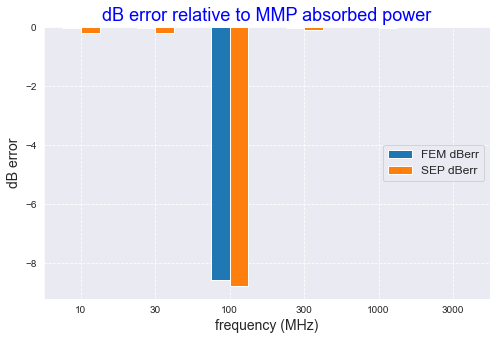

In [85]:
sn.set_style("dark")
ax = dfr.plot.bar(x='f (MHz)',y=['FEM dBerr','SEP dBerr'],
                  rot=0,figsize=(8,5));
plt.title('dB error relative to MMP absorbed power',
          fontsize=18,c='b')
plt.ylabel('dB error',fontsize=14)
plt.xlabel('frequency (MHz)',fontsize=14)
plt.grid(ls='--')
plt.legend(loc='center right',fontsize=12);